# **Transfer Learning On Plant Seedlings Dataset**



---

This notebook is laid out as follows:



1.   **Part 1:** Loading,Transforming and One Hot Encoding 
2.   **Part 2:** Data Augmentation
3.  **Part 3:** Using Pre Trained models(Includes Saving and Loading)




## **Part 1: Loading,Transforming and One Hot Encoding**


In [1]:
import os
import fnmatch
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.applications.vgg16 import preprocess_input
from keras.applications.inception_v3 import preprocess_input
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
np.random.seed(21)



import tensorflow as tf
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,BatchNormalization,Activation,Dropout,GlobalAveragePooling2D
from keras.models import Sequential,Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam


a = '/kaggle/input/plant-seedlings-classification'

print(os.listdir(os.path.join(a,'train')))

['Scentless Mayweed', 'Common wheat', 'Charlock', 'Black-grass', 'Sugar beet', 'Loose Silky-bent', 'Maize', 'Cleavers', 'Common Chickweed', 'Fat Hen', 'Small-flowered Cranesbill', 'Shepherds Purse']


In [2]:
    from sklearn.metrics import accuracy_score


In [3]:
def get_train_data(root):
    
    """Performs required pre processing on the input images and fetches data

    Args:
      root: Directory in which we are working

    Returns: 
      train_img: A numpy array consisting of train images
      train_y : A OHE numpy array of train labels
    """
    train_dir = (os.path.join(root,'train'))
    train_label = []
    train_img = []
    label2num = {'Loose Silky-bent':0, 'Charlock':1, 'Sugar beet':2, 'Small-flowered Cranesbill':3,
                 'Common Chickweed':4, 'Common wheat':5, 'Maize':6, 'Cleavers':7, 'Scentless Mayweed':8,
                 'Fat Hen':9, 'Black-grass':10, 'Shepherds Purse':11}
    for i in os.listdir(train_dir):
        label_number = label2num[i]
        new_path = os.path.join(train_dir,i)
        for j in fnmatch.filter(os.listdir(new_path), '*.png'):
            temp_img = image.load_img(os.path.join(new_path,j), target_size=(128,128))
            train_label.append(label_number)
            temp_img = image.img_to_array(temp_img)
            train_img.append(temp_img)
        print(i)
    train_img = np.array(train_img)

    train_y=pd.get_dummies(train_label)
    train_y = np.array(train_y)
    train_img=preprocess_input(train_img)
    
    return train_img,train_y



In [4]:
train_img,train_y = get_train_data(a)
print('Training data shape: ', train_img.shape)
print('Training labels shape: ', train_y.shape)

Scentless Mayweed
Common wheat
Charlock
Black-grass
Sugar beet
Loose Silky-bent
Maize
Cleavers
Common Chickweed
Fat Hen
Small-flowered Cranesbill
Shepherds Purse
Training data shape:  (4750, 128, 128, 3)
Training labels shape:  (4750, 12)


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid=train_test_split(train_img,train_y,test_size=0.1, random_state=42)

## **Part 2: Data Augmentation**


In [6]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen.fit(X_train)


## **Part 3- Transfer Learing**

### **1) VGG-16**

#### **Customizing VGG-16 for our problem statement**

In [7]:
def vgg16_model(num_classes=None):
    
    """ Adding custom model to the VGG-16

    Args:
      num_classes: Number of layers in the final layer(Number of classes)

    Returns:
      model: Returns the custom model added to VGG
    """

    model = VGG16(weights='imagenet', include_top=False,input_shape=(128,128,3))
    model.layers.pop()
    model.layers.pop()
    model.layers.pop()

    model.outputs = [model.layers[-1].output]

    #model.layers[-2].outbound_node= []
    x=Conv2D(256, kernel_size=(2,2),strides=2)(model.output)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)    
    x=Conv2D(128, kernel_size=(2,2),strides=1)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x=Flatten()(x)
    x=Dense(num_classes, activation='softmax')(x)

    model=Model(model.input,x)

    for layer in model.layers[:15]:

        layer.trainable = False


    return model

In [8]:
from keras.applications.vgg16 import VGG16
from keras import backend as K
num_classes=12
model = vgg16_model(num_classes)
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
______________________________________________________________

#### **Training VGG-16**

In [9]:
from keras.callbacks import ModelCheckpoint
epochs = 10
batch_size = 32
model_checkpoint = ModelCheckpoint('vgg_weights.h5', monitor='val_accuracy', save_best_only=True,mode='max',verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=7, min_lr=0.000001)
#early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=7, verbose=0, mode='min', restore_best_weights=True)

model.fit(datagen.flow(X_train,Y_train),
          batch_size=128,
          epochs=20,
          verbose=1, shuffle=True, validation_data=(X_valid,Y_valid), callbacks=[model_checkpoint,reduce_lr])

Epoch 1/20
134/134 [==============================] - ETA: 0s - loss: 1.3136 - accuracy: 0.5464
Epoch 00001: val_accuracy improved from -inf to 0.59158, saving model to vgg_weights.h5
134/134 [==============================] - 19s 143ms/step - loss: 1.3136 - accuracy: 0.5464 - val_loss: 1.5396 - val_accuracy: 0.5916 - lr: 0.0010
Epoch 2/20
134/134 [==============================] - ETA: 0s - loss: 0.6790 - accuracy: 0.7600
Epoch 00002: val_accuracy improved from 0.59158 to 0.62737, saving model to vgg_weights.h5
134/134 [==============================] - 18s 132ms/step - loss: 0.6790 - accuracy: 0.7600 - val_loss: 1.2796 - val_accuracy: 0.6274 - lr: 0.0010
Epoch 3/20
134/134 [==============================] - ETA: 0s - loss: 0.5614 - accuracy: 0.8049
Epoch 00003: val_accuracy improved from 0.62737 to 0.68211, saving model to vgg_weights.h5
134/134 [==============================] - 17s 130ms/step - loss: 0.5614 - accuracy: 0.8049 - val_loss: 1.1109 - val_accuracy: 0.6821 - lr: 0.0010
E

In [10]:
plt.style.use('seaborn')

# Accuracy History
def accuracy_curves(m):
    """ Plots the Train and validation Accuracy Curves

    Args:
      m: Model for which the curves are plotted

    Returns:
      
    """
    
    plt.figure(1, figsize=(16, 10))
    plt.plot(m.history.history['accuracy'])
    plt.plot(m.history.history['val_accuracy'])
    plt.title('Train and Validation Accuracy', fontsize = 16)
    plt.ylabel('Accuracy', fontsize = 14)
    plt.xlabel('Epoch', fontsize = 14)
    plt.legend(['Train', 'Test'], fontsize = 14)
    plt.show()
    
# Loss History

def loss_curves(m):
    """ Plots the Train and validation Loss Curves

    Args:
      m: Model for which the curves are plotted

    Returns:
      
    """
    plt.figure(2, figsize=(16, 10))
    plt.plot(m.history.history['loss'])
    plt.plot(m.history.history['val_loss'])
    plt.title('Train and Validation Loss', fontsize = 16)
    plt.ylabel('Loss', fontsize = 14)
    plt.xlabel('Epoch', fontsize = 14)
    plt.legend(['Train', 'Test'], fontsize = 14)
    plt.show()

    
from sklearn.metrics import classification_report

def class_report(m):
    """ Creates  Classification Report 

    Args:
      m: Model for which the report is generated

    Returns:
      
    """
    target_names = os.listdir(os.path.join(a,'train'))
    print(classification_report(Y_valid.argmax(axis=1), m.predict(X_valid).argmax(axis=1), target_names=target_names))
    
    
from sklearn.metrics import confusion_matrix

def conf_matrix(m):
    """ Creates  Confusion Matrix 

    Args:
      m: Model for which the confusion matrix is generated

    Returns:
      
    """
    target_names = os.listdir(os.path.join(a,'train'))
    cf_matrix = confusion_matrix(Y_valid.argmax(axis=1), np.round(m.predict(X_valid).argmax(axis=1),0))
    plt.figure(figsize=(20,20))
    sns.heatmap(cf_matrix/100, annot=True, xticklabels=target_names, yticklabels=target_names, cmap='Blues')

#### **Visualizing Loss and Accuracy(VGG-16)**

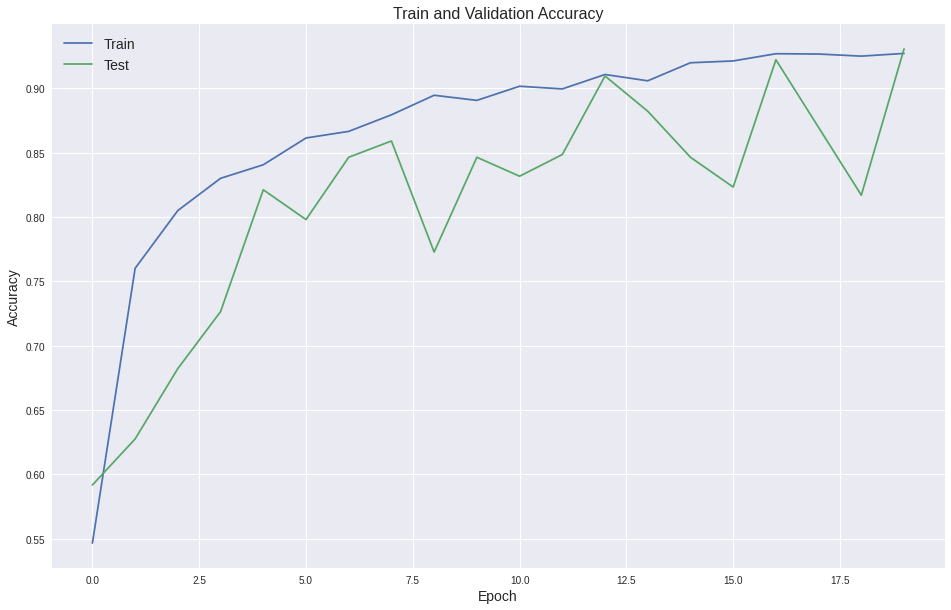

In [11]:
accuracy_curves(model)

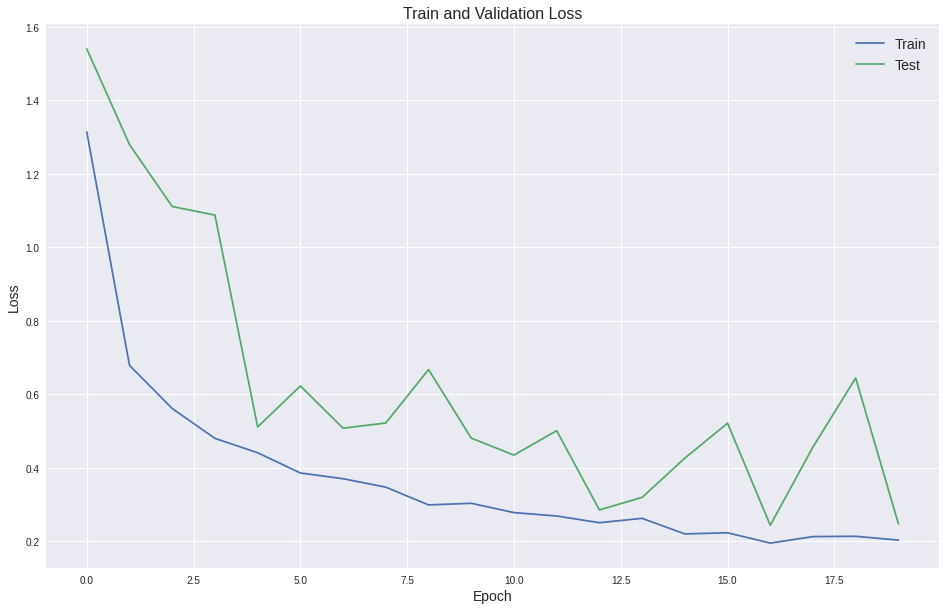

In [12]:
loss_curves(model)

#### **Classification Report**

In [13]:
class_report(model)

                           precision    recall  f1-score   support

        Scentless Mayweed       0.91      0.88      0.90        59
             Common wheat       0.97      0.95      0.96        41
                 Charlock       1.00      0.87      0.93        30
              Black-grass       0.97      0.98      0.97        59
               Sugar beet       0.99      0.95      0.97        76
         Loose Silky-bent       0.76      1.00      0.86        25
                    Maize       0.91      1.00      0.95        20
                 Cleavers       1.00      0.93      0.96        29
         Common Chickweed       0.98      0.96      0.97        57
                  Fat Hen       0.93      0.93      0.93        42
Small-flowered Cranesbill       0.55      0.61      0.58        18
          Shepherds Purse       0.95      0.95      0.95        19

                 accuracy                           0.93       475
                macro avg       0.91      0.92      0.91    

#### **Confusion matrix**

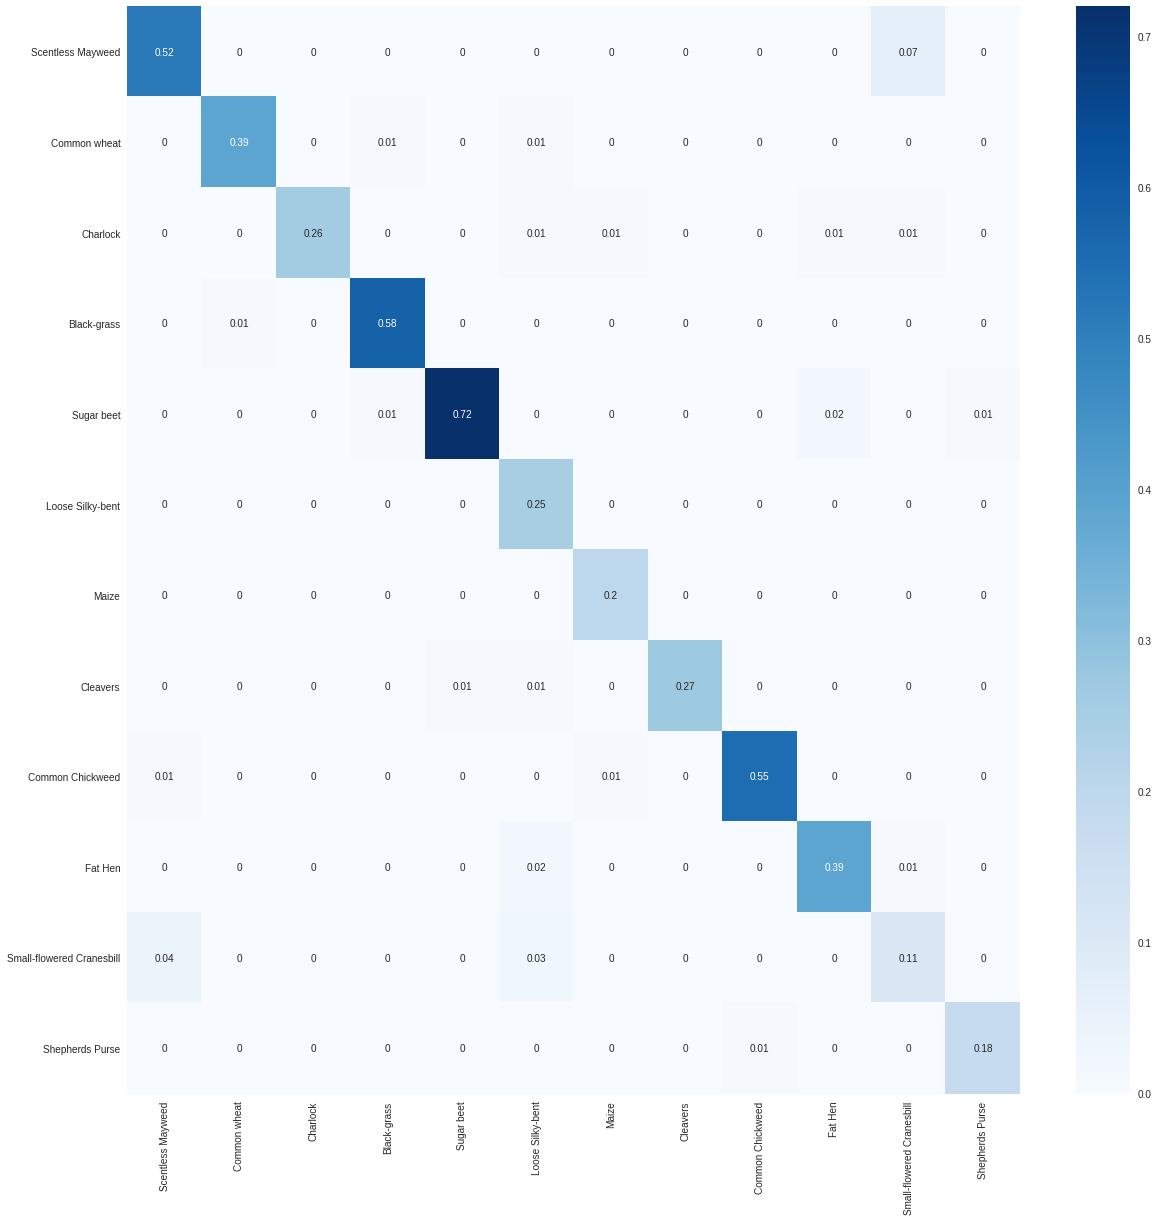

In [14]:
conf_matrix(model)

#### Model Optimization Using TF-Lite(Post Training Dynamic range quantization) 

In [15]:
import pathlib

In [16]:
tflite_models_dir = pathlib.Path(os.path.join(os.getcwd(),'tflite_models'))
tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [17]:
converter_vgg = tf.lite.TFLiteConverter.from_keras_model(model)


In [18]:
# Convert to TF Lite without quantization
vgg16_tflite_file = tflite_models_dir/"vgg16.tflite"
vgg16_tflite_file.write_bytes(converter_vgg.convert())

61498040

In [19]:
interpreter = tf.lite.Interpreter(model_path='./tflite_models/vgg16.tflite')
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.float32'>
output:  <class 'numpy.float32'>


In [20]:
def run_tflite_model(tflite_file, test_image_indices):
    global X_valid

  # Initialize the interpreter
    interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    predictions = np.zeros((len(test_image_indices),), dtype=int)
    for i, test_image_index in enumerate(test_image_indices):
        test_image = X_valid[test_image_index]
        test_label = Y_valid[test_image_index]

        test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
        interpreter.set_tensor(input_details["index"], test_image)
        interpreter.invoke()
        output = interpreter.get_tensor(output_details["index"])[0]

        predictions[i] = output.argmax()

    return predictions

In [21]:
def evaluate_model(tflite_file, model_type):
    global X_valid
    global Y_valid

    test_image_indices = range(X_valid.shape[0])
    predictions = run_tflite_model(tflite_file, test_image_indices)
    
    predictions=pd.get_dummies(predictions)
    predictions = np.array(predictions)
    #print(predictions)
    
    accuracy = accuracy_score(y_true=Y_valid, y_pred=predictions) 

    #accuracy = (np.sum(Y_valid== predictions) * 100) / len(X_valid)

    return accuracy

In [22]:
op = evaluate_model(vgg16_tflite_file, model_type="Float")
print("Accuracy of TFLite - VGG : {}".format(op))

Accuracy of TFLite - VGG : 0.9305263157894736


#### Optimization of VGG Model with TensorRT

In [23]:
from tensorflow.python.compiler.tensorrt import trt_convert as trt


In [24]:
model.save('vgg_saved_model')

In [25]:
print('Converting to TF-TRT FP32...')
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(precision_mode=trt.TrtPrecisionMode.FP32,
                                                               max_workspace_size_bytes=8000000000)

converter = trt.TrtGraphConverterV2(input_saved_model_dir='vgg_saved_model',
                                    conversion_params=conversion_params)
converter.convert()
converter.save(output_saved_model_dir='vgg_saved_model_TFTRT_FP32')
print('Done Converting to TF-TRT FP32')

Converting to TF-TRT FP32...
Done Converting to TF-TRT FP32


In [26]:
!saved_model_cli show --all --dir vgg_saved_model_TFTRT_FP32

2021-09-26 15:00:23.221732: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 128, 128, 3)
        name: serving_default_input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 12)
        name: PartitionedCall:0
  Method name is: tensorflow/serving/p

In [27]:
batch_size = 8
batched_input = np.zeros((batch_size, 128, 128, 3), dtype=np.float32)

for i in range(batch_size):
    img_path = '../input/plant-seedlings-classification/train/Common Chickweed'
    for j in os.listdir(img_path):
        img = image.load_img(os.path.join(img_path,j), target_size=(128, 128))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        batched_input[i, :] = x
batched_input = tf.constant(batched_input)
print('batched_input shape: ', batched_input.shape)

batched_input shape:  (8, 128, 128, 3)


In [28]:
import time

In [29]:
def benchmark_tftrt(input_saved_model):
    saved_model_loaded = tf.saved_model.load(input_saved_model, tags=[tag_constants.SERVING])
    infer = saved_model_loaded.signatures['serving_default']

    N_warmup_run = 50
    N_run = 500
    elapsed_time = []

    for i in range(N_warmup_run):
        labeling = infer(batched_input)

    for i in range(N_run):
        start_time = time.time()
        labeling = infer(batched_input)
        #prob = labeling['probs'].numpy()
        end_time = time.time()
        elapsed_time = np.append(elapsed_time, end_time - start_time)
        if i % 50 == 0:
            print('Step {}: {:4.1f}ms'.format(i, (elapsed_time[-50:].mean()) * 1000))

    print('Throughput: {:.0f} images/s'.format(N_run * batch_size / elapsed_time.sum()))

### **2) ResNet50**

#### **Customizing ResNet50 for our problem statement**

In [31]:
def resnet_model(num_classes=None):
    
    """ Adding custom model to the ResNet50

    Args:
      num_classes: Number of layers in the final layer(Number of classes)

    Returns:
      model: Returns the custom model added to ResNet
    """

    model = ResNet50(weights='imagenet', include_top=False,input_shape=(128,128,3))
    model.layers.pop()
    #model.layers.pop()
    #model.layers.pop()

    model.outputs = [model.layers[-1].output]

    #model.layers[-2].outbound_node= []
    x=Conv2D(256, kernel_size=(2,2),strides=2)(model.output)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)    
    x=Conv2D(128, kernel_size=(2,2),strides=1)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x=Flatten()(x)
    x=Dense(num_classes, activation='softmax')(x)

    model=Model(model.input,x)

    for layer in model.layers[:15]:

        layer.trainable = False


    return model

In [32]:
from keras.applications.resnet50 import ResNet50
from keras import backend as K
num_classes=12
model_res = resnet_model(num_classes)
model_res.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model_res.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
___________________________

#### **Training ResNet50**

In [33]:
epochs = 10
batch_size = 32
model_checkpoint = ModelCheckpoint('resnet_weights.h5', monitor='val_accuracy', save_best_only=True,mode='max',verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=7, min_lr=0.000001)
#early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=7, verbose=0, mode='min', restore_best_weights=True)

model_res.fit(datagen.flow(X_train,Y_train),
          batch_size=128,
          epochs=20,
          verbose=1, shuffle=True, validation_data=(X_valid,Y_valid), callbacks=[model_checkpoint,reduce_lr])

Epoch 1/20
134/134 [==============================] - ETA: 0s - loss: 1.2274 - accuracy: 0.5967
Epoch 00001: val_accuracy improved from -inf to 0.20632, saving model to resnet_weights.h5
134/134 [==============================] - 22s 166ms/step - loss: 1.2274 - accuracy: 0.5967 - val_loss: 8.3277 - val_accuracy: 0.2063 - lr: 0.0010
Epoch 2/20
134/134 [==============================] - ETA: 0s - loss: 0.6740 - accuracy: 0.7743
Epoch 00002: val_accuracy improved from 0.20632 to 0.40842, saving model to resnet_weights.h5
134/134 [==============================] - 21s 160ms/step - loss: 0.6740 - accuracy: 0.7743 - val_loss: 2.8029 - val_accuracy: 0.4084 - lr: 0.0010
Epoch 3/20
134/134 [==============================] - ETA: 0s - loss: 0.5602 - accuracy: 0.8051
Epoch 00003: val_accuracy did not improve from 0.40842
134/134 [==============================] - 19s 144ms/step - loss: 0.5602 - accuracy: 0.8051 - val_loss: 3.9130 - val_accuracy: 0.3326 - lr: 0.0010
Epoch 4/20
134/134 [===========

#### **Visualizing Loss and Accuracy(ResNet50)**

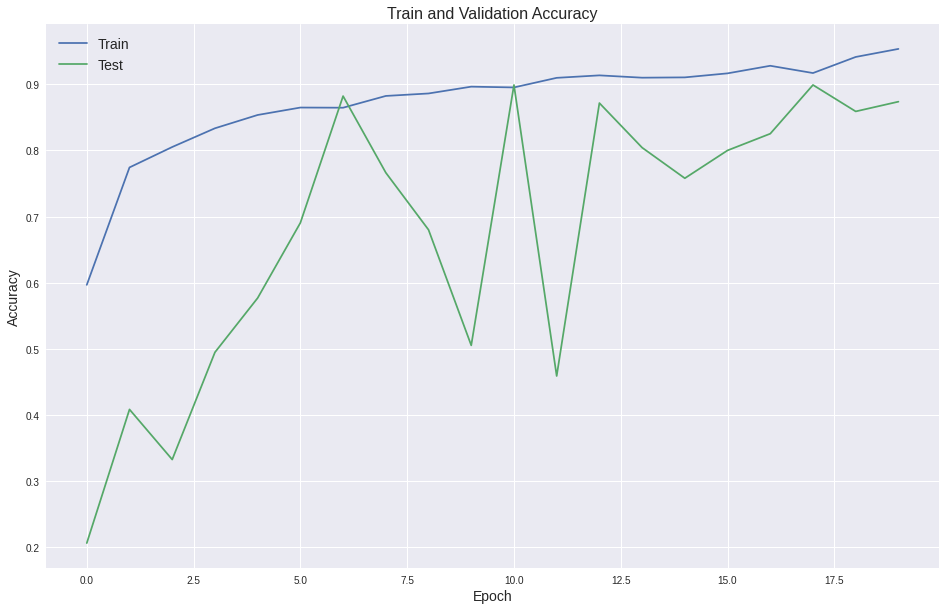

In [34]:
accuracy_curves(model_res)

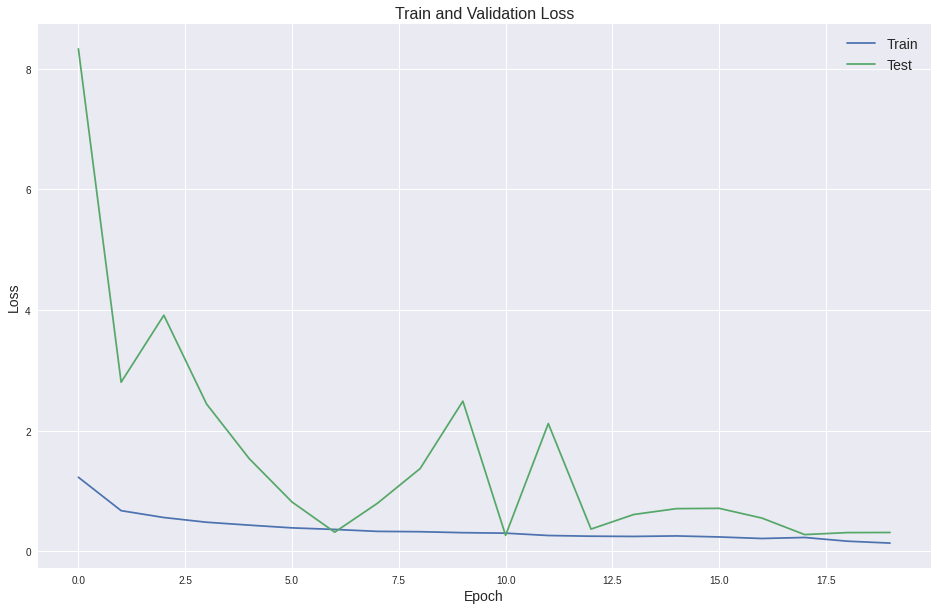

In [35]:
loss_curves(model_res)

#### **Classification Report**

In [36]:
class_report(model_res)

                           precision    recall  f1-score   support

        Scentless Mayweed       1.00      0.42      0.60        59
             Common wheat       0.93      0.98      0.95        41
                 Charlock       0.90      0.93      0.92        30
              Black-grass       1.00      0.95      0.97        59
               Sugar beet       0.97      0.95      0.96        76
         Loose Silky-bent       0.83      1.00      0.91        25
                    Maize       0.71      1.00      0.83        20
                 Cleavers       0.96      0.83      0.89        29
         Common Chickweed       0.95      0.95      0.95        57
                  Fat Hen       0.98      1.00      0.99        42
Small-flowered Cranesbill       0.29      0.78      0.42        18
          Shepherds Purse       1.00      0.79      0.88        19

                 accuracy                           0.87       475
                macro avg       0.88      0.88      0.86    

#### **Confusion matrix**

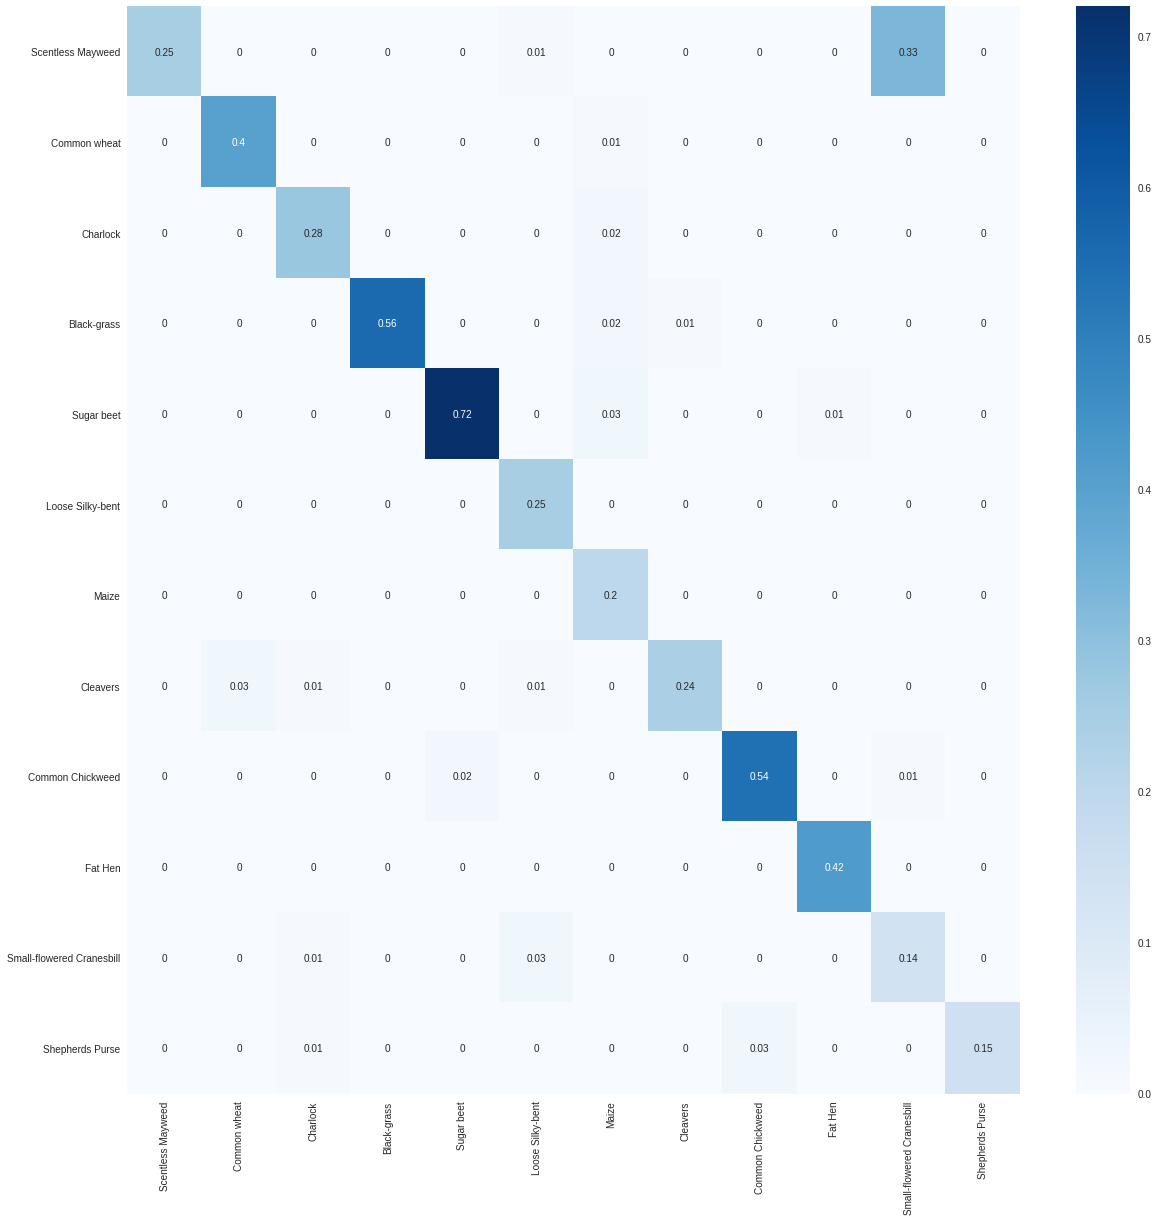

In [37]:
conf_matrix(model_res)

#### Model Optimization Using TF-Lite(Post Training Dynamic range quantization) 

In [38]:
converter_resnet = tf.lite.TFLiteConverter.from_keras_model(model_res)


In [39]:
# Convert to TF Lite without quantization
resnet_tflite_file = tflite_models_dir/"resnet.tflite"
resnet_tflite_file.write_bytes(converter_resnet.convert())

102920128

In [40]:
interpreter = tf.lite.Interpreter(model_path='./tflite_models/resnet.tflite')
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.float32'>
output:  <class 'numpy.float32'>


In [41]:
op = evaluate_model(resnet_tflite_file, model_type="Float")
print("Accuracy of TFLite - Resnet50 : {}".format(op))

Accuracy of TFLite - Resnet50 : 0.8736842105263158


#### Optimization of Resnet Model with TensorRT

In [42]:
model_res.save('res_saved_model')

In [43]:
print('Converting to TF-TRT FP16...')
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
    precision_mode=trt.TrtPrecisionMode.FP16,
    max_workspace_size_bytes=8000000000)
converter = trt.TrtGraphConverterV2(
   input_saved_model_dir='res_saved_model', conversion_params=conversion_params)
converter.convert()
converter.save(output_saved_model_dir='res_saved_model_TFTRT_FP16')
print('Done Converting to TF-TRT FP16')

Converting to TF-TRT FP16...
Done Converting to TF-TRT FP16


In [ ]:
benchmark_tftrt('res_saved_model_TFTRT_FP16')

### **3) InceptionV3**

#### **Customizing InceptionV3 for our problem statement**

In [44]:
def incep_model(num_classes=None):
    
    """ Adding custom model to the InceptionV3

    Args:
      num_classes: Number of layers in the final layer(Number of classes)

    Returns:
      model: Returns the custom model added to Inception
    """

    model = InceptionV3(weights='imagenet', include_top=False,input_shape=(128,128,3))
    #model.layers.pop()
    #model.layers.pop()
    #model.layers.pop()

#    for layer in model.layers:
 #     layer.trainable = False
    '''
    model.outputs = model.output
    
    x = GlobalAveragePooling2D()(model.outputs)
    #x=Conv2D(256, kernel_size=(2,2),strides=2)(model.output)
    #x = BatchNormalization()(x)    
    #x=Conv2D(128, kernel_size=(2,2),strides=1)(x)
    #x = Activation('relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(128,activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)
    #x=Flatten()(x)
    x=Dense(num_classes, activation='softmax')(x)

    model=Model(model.input,x)'''

    
    x = model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.3)(x)
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.3)(x)

    predictions = Dense(12, activation='softmax')(x)

    model = Model(model.input, predictions)




    return model

In [45]:
from keras.applications.inception_v3 import InceptionV3
from keras import backend as K
num_classes=12
model_incep = incep_model(num_classes)
model_incep.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model_incep.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 63, 63, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 63, 63, 32)   96          conv2d_4[0][0]                   
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 63, 63, 32)   0           batch_normalization_4[0][0]      
___________________________

#### **Training InceptionV3**

In [46]:
epochs = 10
batch_size = 32
model_checkpoint = ModelCheckpoint('incep_weights.h5', monitor='val_accuracy', save_best_only=True,mode='max',verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=7, min_lr=0.000001)
#early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=7, verbose=0, mode='min', restore_best_weights=True)

model_incep.fit(datagen.flow(X_train,Y_train),
          batch_size=128,
          epochs=20,
          verbose=1, shuffle=True, validation_data=(X_valid,Y_valid), callbacks=[model_checkpoint])

Epoch 1/20
134/134 [==============================] - ETA: 0s - loss: 2.0340 - accuracy: 0.3591
Epoch 00001: val_accuracy improved from -inf to 0.09895, saving model to incep_weights.h5
134/134 [==============================] - 23s 173ms/step - loss: 2.0340 - accuracy: 0.3591 - val_loss: 4.5273 - val_accuracy: 0.0989
Epoch 2/20
134/134 [==============================] - ETA: 0s - loss: 1.0784 - accuracy: 0.6580
Epoch 00002: val_accuracy improved from 0.09895 to 0.29895, saving model to incep_weights.h5
134/134 [==============================] - 22s 161ms/step - loss: 1.0784 - accuracy: 0.6580 - val_loss: 3.0248 - val_accuracy: 0.2989
Epoch 3/20
134/134 [==============================] - ETA: 0s - loss: 0.8119 - accuracy: 0.7551
Epoch 00003: val_accuracy did not improve from 0.29895
134/134 [==============================] - 20s 149ms/step - loss: 0.8119 - accuracy: 0.7551 - val_loss: 4.4561 - val_accuracy: 0.2947
Epoch 4/20
134/134 [==============================] - ETA: 0s - loss: 0.

#### **Visualizing Loss and Accuracy(InceptionV3)**

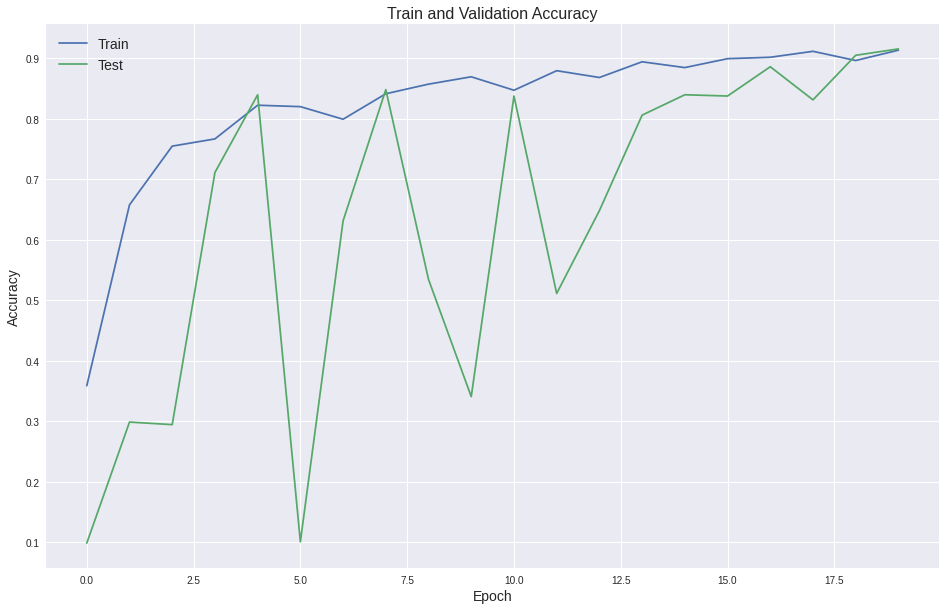

In [47]:
accuracy_curves(model_incep)

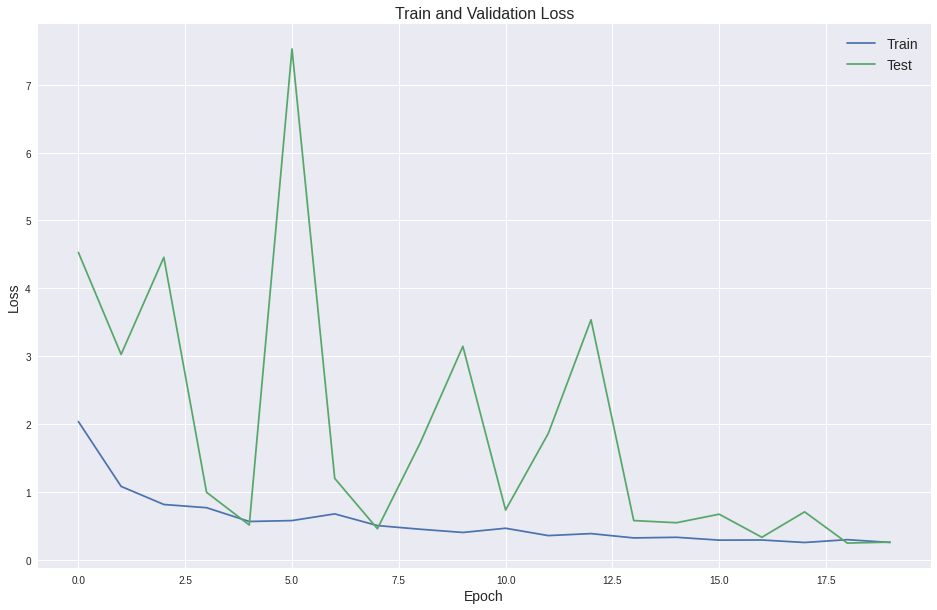

In [48]:
loss_curves(model_incep)

#### **Classification Report**

In [49]:
class_report(model_incep)

                           precision    recall  f1-score   support

        Scentless Mayweed       0.84      0.95      0.89        59
             Common wheat       0.90      0.88      0.89        41
                 Charlock       0.91      0.97      0.94        30
              Black-grass       1.00      0.98      0.99        59
               Sugar beet       0.94      1.00      0.97        76
         Loose Silky-bent       0.92      0.96      0.94        25
                    Maize       0.77      1.00      0.87        20
                 Cleavers       1.00      0.66      0.79        29
         Common Chickweed       1.00      0.89      0.94        57
                  Fat Hen       0.95      1.00      0.98        42
Small-flowered Cranesbill       0.60      0.33      0.43        18
          Shepherds Purse       0.86      0.95      0.90        19

                 accuracy                           0.92       475
                macro avg       0.89      0.88      0.88    

#### **Confusion Matrix**

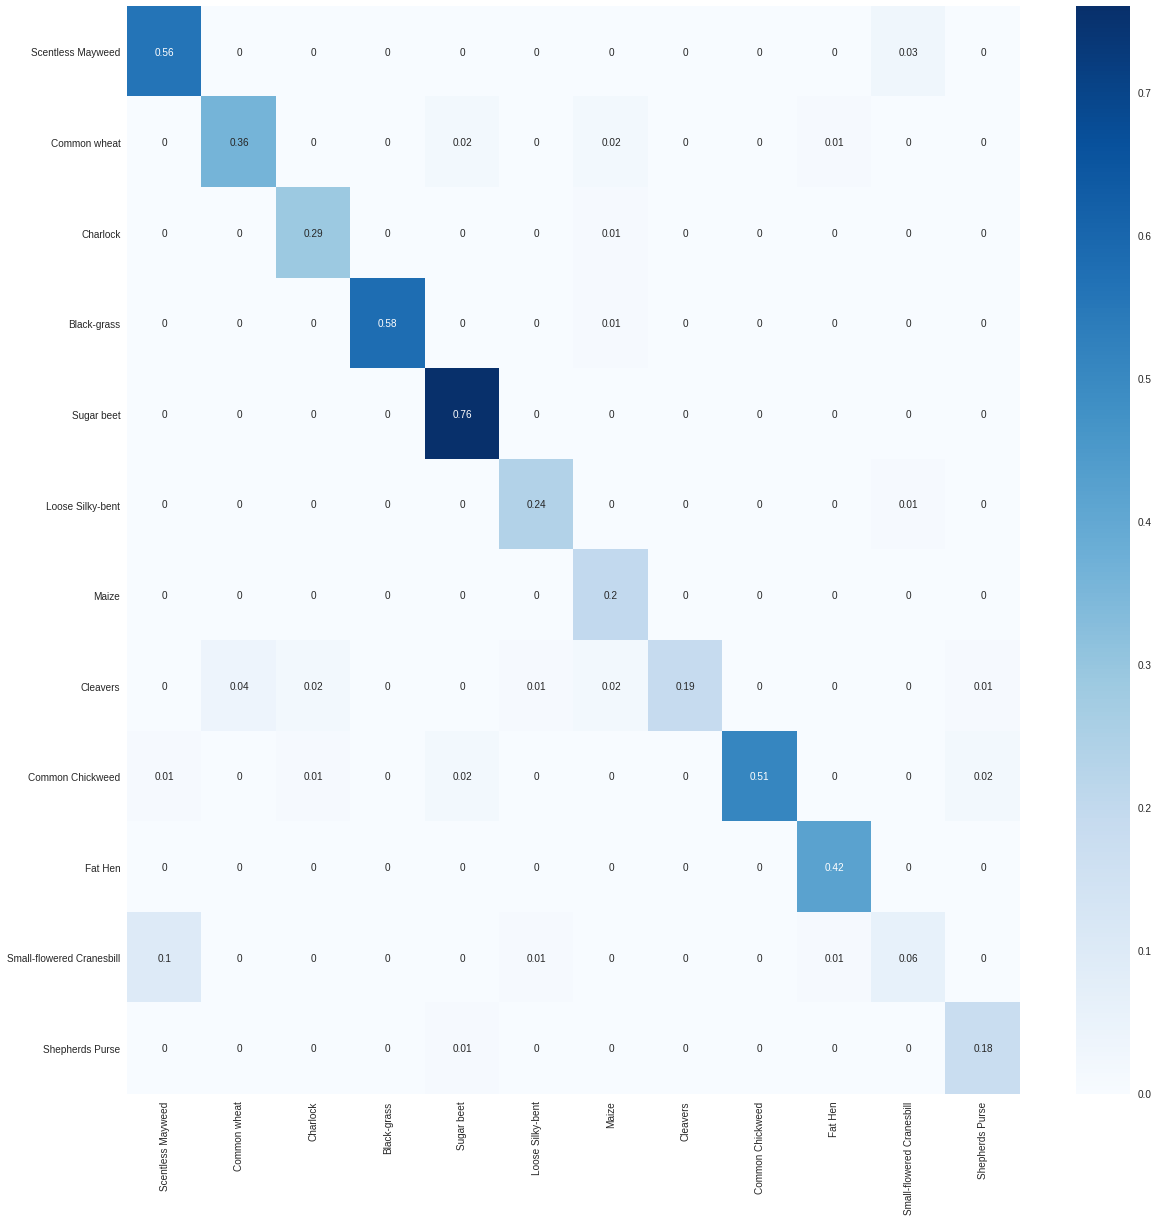

In [50]:
conf_matrix(model_incep)

#### Model Optimization Using TF-Lite(Post Training Dynamic range quantization) 

In [51]:
converter_incep = tf.lite.TFLiteConverter.from_keras_model(model_incep)

In [52]:
# Convert to TF Lite without quantization
incep_tflite_file = tflite_models_dir/"incep.tflite"
incep_tflite_file.write_bytes(converter_incep.convert())

97674980

In [53]:
interpreter = tf.lite.Interpreter(model_path='./tflite_models/incep.tflite')
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.float32'>
output:  <class 'numpy.float32'>


In [54]:
op = evaluate_model(incep_tflite_file, model_type="Float")
print("Accuracy of TFLite - InceptionV3 : {}".format(op))

Accuracy of TFLite - InceptionV3 : 0.9157894736842105


#### Optimization of InceptionV3 Model with TensorRT

In [ ]:
model_incep.save('incep_saved_model')

In [ ]:
benchmark_tftrt('incep_saved_model_TFTRT_FP16')

## **Saving,Loading and Predicting on test set**

### The validation accuracies obtained for each model are as follows:

**1. VGG-16 - 91.789**

**2. ResNet50 - 95.368**

**3. InceptionV3 - 89.895** 

As per the question, we choose the model with the highest validation accuracy for predictions on test set i.e ResNet50.

In [ ]:
!mkdir -p saved_models


In [ ]:
model.save('m_vgg.h5')
model_res.save('m_res.h5')
model_incep.save('m_incep.h5')

## **Saved Models**

[![Screenshot-2020-08-11-at-11-33-23-AM.png](https://i.postimg.cc/Ls9kkXD0/Screenshot-2020-08-11-at-11-33-23-AM.png)](https://postimg.cc/0z4JP9Lp)

In [ ]:
new_model = tf.keras.models.load_model('m_res.h5')

In [ ]:
new_model.summary()

In [ ]:
def predict_on_test(model):
    """ Using the Model with the highest Validation accuracy to predict on test set

    Args:
      model: Model with highest validation accuracy(ResNet50)

    Returns:
      df: A Dataframe in a format required by Kaggle 
    """
    prob=[]
    num=[]
    test_img=[]
    test_path = os.path.join('/kaggle/input/plant-seedlings-classification','test')
    test_all = fnmatch.filter(os.listdir(test_path), '*.png')

    test_img=[]
    for i in range(len(test_all)):
        path=test_path+'/'+test_all[i]
        temp_img=image.load_img(path,target_size=(128,128))
        temp_img=image.img_to_array(temp_img)
        test_img.append(temp_img) 
    test_img=np.array(test_img)    
    test_img= tf.keras.applications.vgg16.preprocess_input(test_img)


    test_labels=[]
    pred=model.predict(test_img)
    num2label =  {0:'Loose Silky-bent', 1:'Charlock',2: 'Sugar beet',3: 'Small-flowered Cranesbill',
                  4:'Common Chickweed',5: 'Common wheat',6: 'Maize', 7:'Cleavers', 8:'Scentless Mayweed',
                 9: 'Fat Hen', 10:'Black-grass', 11:'Shepherds Purse'}
    for i in range(len(test_all)):
        max_score =0
        lab=-1
        for j in range(12):
            if pred[i][j]>max_score:
                max_score=pred[i][j]
                lab=j
        test_labels.append(num2label[lab])


    d = {'file': test_all, 'species': test_labels}
    df = pd.DataFrame(data=d)
    return df

In [ ]:
df = predict_on_test(new_model)
print(df.head(5))
df.to_csv("/kaggle/working/submit.csv",index=False) 

# Score on test Set

Received a score of 0.94 on the ResNet50 model


[![Res-Net-Score.png](https://i.postimg.cc/j5Tb3Hph/Res-Net-Score.png)](https://postimg.cc/jWMmL7dW)